<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         4801 non-null   object 
 1   shots            4801 non-null   float64
 2   shots_on_target  4801 non-null   float64
 3   home_xG          4801 non-null   float64
 4   away_xG          4801 non-null   float64
 5   result           4801 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 225.2+ KB
None
             shots  shots_on_target      home_xG      away_xG       result
count  4801.000000      4801.000000  4801.000000  4801.000000  4801.000000
mean      0.882429         0.298500     1.556655     1.272381     0.569673
std       0.207424         0.107928     0.864365     0.770624     0.495173
min       0.185185         0.000000     0.000000     0.000000     0.000000
25%       0.740741         0.222222     0.900000     0.700000     0.000000
50%    

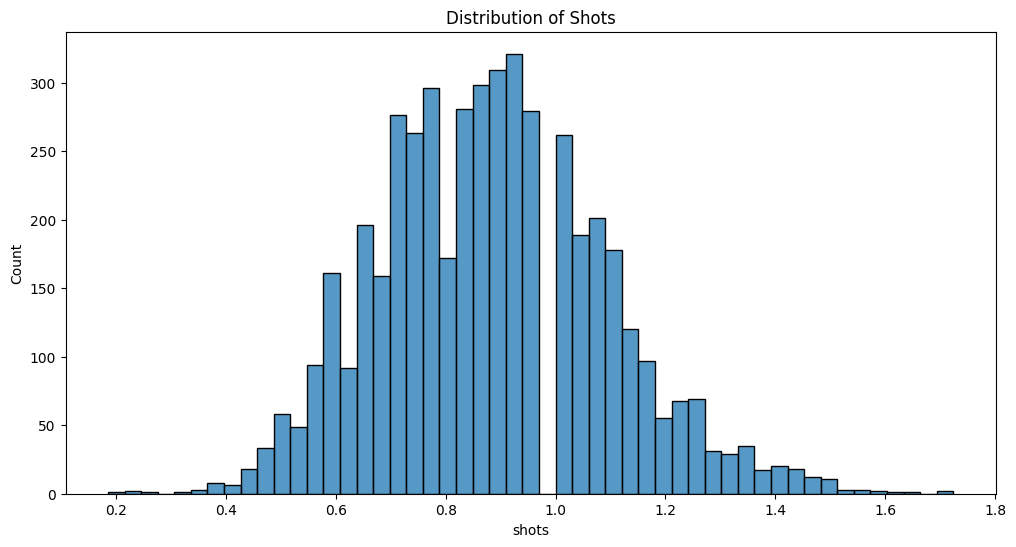

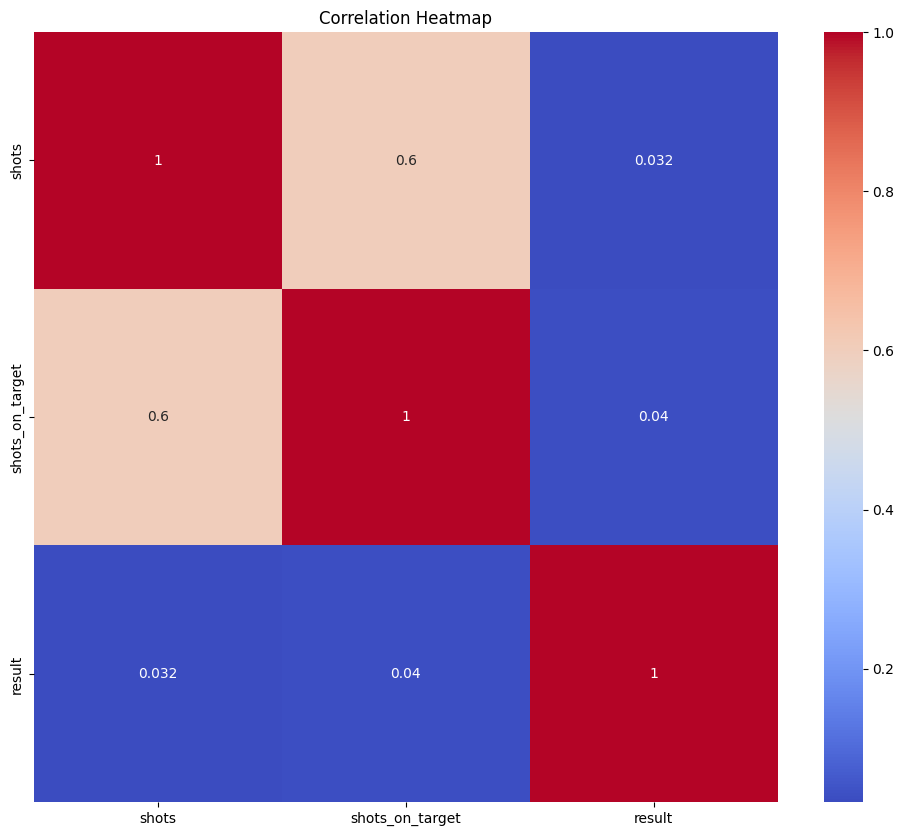

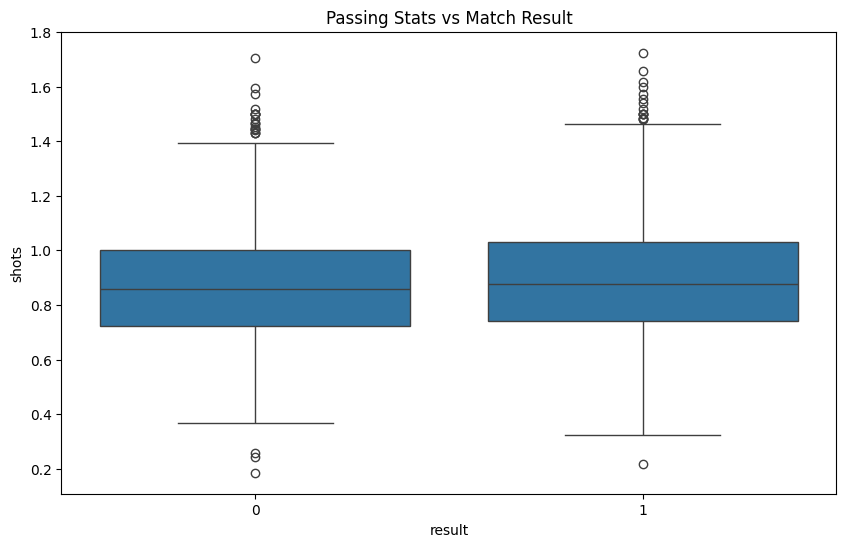

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('../../data/processed/football_data.csv')

# Display basic information
print(data.info())
print(data.describe())

# Visualize distributions of key features
plt.figure(figsize=(12, 6))
sns.histplot(data['shots'])
plt.title('Distribution of Shots')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data[['shots', 'shots_on_target', 'result']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Relationship between a key stat and the match result
plt.figure(figsize=(10, 6))
sns.boxplot(x='result', y='shots', data=data)
plt.title('Passing Stats vs Match Result')
plt.show()